In [1]:
import pandas as pd

X_train = pd.read_csv("../data/X_train.csv")
X_val = pd.read_csv("../data/X_val.csv")

y_train = pd.read_csv("../data/y_train.csv")["Label"]
y_val = pd.read_csv("../data/y_val.csv")["Label"]

In [2]:
# Check and fix data types in X
non_numeric = X_train.select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print("Non-numeric columns found in X_train:", non_numeric)
    # Optionally drop or encode them
    X_train = X_train.drop(columns=non_numeric)
    X_val = X_val.drop(columns=non_numeric)

# Ensure y is numeric
y_train = pd.to_numeric(y_train, errors='coerce')
y_val = pd.to_numeric(y_val, errors='coerce')

In [3]:
import numpy as np

print("NaNs in y_train:", y_train.isna().sum())
print("Infs in y_train:", np.isinf(y_train).sum())
print("NaNs in y_val:", y_val.isna().sum())
print("Infs in y_val:", np.isinf(y_val).sum())

# Combine and clean training set
train_mask = y_train.notna() & ~np.isinf(y_train)
X_train = X_train[train_mask]
y_train = y_train[train_mask]

# Combine and clean validation set
val_mask = y_val.notna() & ~np.isinf(y_val)
X_val = X_val[val_mask]
y_val = y_val[val_mask]

NaNs in y_train: 0
Infs in y_train: 0
NaNs in y_val: 0
Infs in y_val: 0


In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Basic training params
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 4,
    "eta": 0.1,
    "verbosity": 1
}

# Train model
evals = [(dtrain, "train"), (dval, "val")]
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals)

[0]	train-auc:1.00000	val-auc:1.00000
[1]	train-auc:1.00000	val-auc:1.00000
[2]	train-auc:1.00000	val-auc:1.00000
[3]	train-auc:1.00000	val-auc:1.00000
[4]	train-auc:1.00000	val-auc:1.00000
[5]	train-auc:1.00000	val-auc:1.00000
[6]	train-auc:1.00000	val-auc:1.00000
[7]	train-auc:1.00000	val-auc:1.00000
[8]	train-auc:1.00000	val-auc:1.00000
[9]	train-auc:1.00000	val-auc:1.00000
[10]	train-auc:1.00000	val-auc:1.00000
[11]	train-auc:1.00000	val-auc:1.00000
[12]	train-auc:1.00000	val-auc:1.00000
[13]	train-auc:1.00000	val-auc:1.00000
[14]	train-auc:1.00000	val-auc:1.00000
[15]	train-auc:1.00000	val-auc:1.00000
[16]	train-auc:1.00000	val-auc:1.00000
[17]	train-auc:1.00000	val-auc:1.00000
[18]	train-auc:1.00000	val-auc:1.00000
[19]	train-auc:1.00000	val-auc:1.00000
[20]	train-auc:1.00000	val-auc:1.00000
[21]	train-auc:1.00000	val-auc:1.00000
[22]	train-auc:1.00000	val-auc:1.00000
[23]	train-auc:1.00000	val-auc:1.00000
[24]	train-auc:1.00000	val-auc:1.00000
[25]	train-auc:1.00000	val-auc:1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33065
           1       1.00      1.00      1.00     16935

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Confusion Matrix:


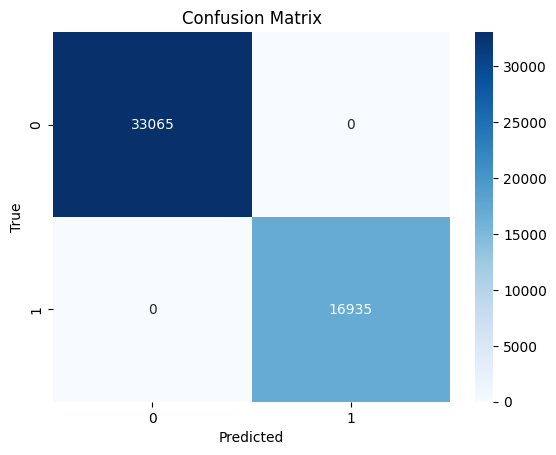

ROC AUC Score: 1.0


In [5]:
# Predict probabilities
y_pred_prob = model.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("ROC AUC Score:", roc_auc_score(y_val, y_pred_prob))

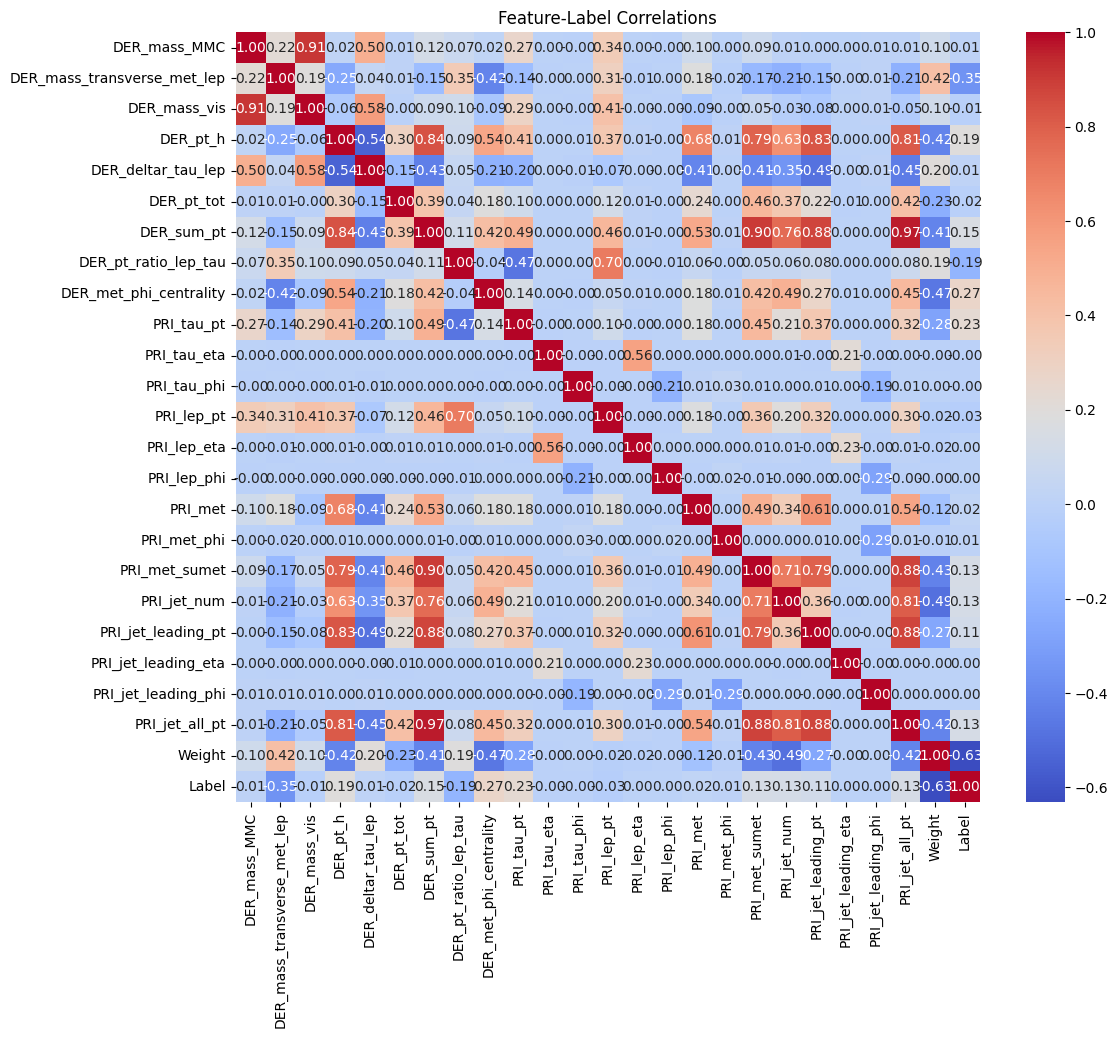

In [17]:
# Correlation matrix heatmap (only numeric features)
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train.join(y_train).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature-Label Correlations")
plt.show()


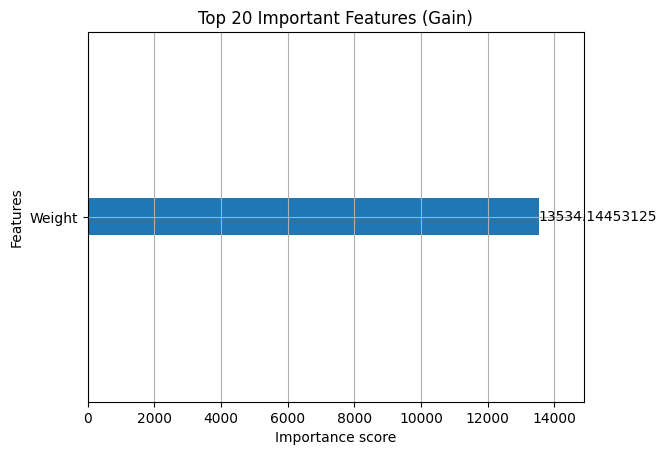

In [6]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.show()

In [8]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

params_no_eval = {k: v for k, v in params.items() if k != 'eval_metric'}

clf = XGBClassifier(**params_no_eval, use_label_encoder=False, eval_metric='auc')

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
print("CV AUC scores:", scores)
print("Mean CV AUC:", scores.mean())

C:\Code\ml-event-classification\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Code\ml-event-classification\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Code\ml-event-classification\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Code\ml-event-classification\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe

CV AUC scores: [1. 1. 1. 1. 1.]
Mean CV AUC: 1.0


In [9]:
model.save_model("xgb_model.json")

# Later load:
loaded_model = xgb.Booster()
loaded_model.load_model("xgb_model.json")

In [11]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

clf = XGBClassifier(eval_metric='auc')
grid = GridSearchCV(clf, grid_params, scoring='roc_auc', cv=3, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.8}


In [13]:
import pandas as pd

results = pd.DataFrame({
    "true_label": y_val,
    "pred_prob": y_pred_prob,
    "pred_class": y_pred
})
results.to_csv("xgb_val_predictions.csv", index=False)

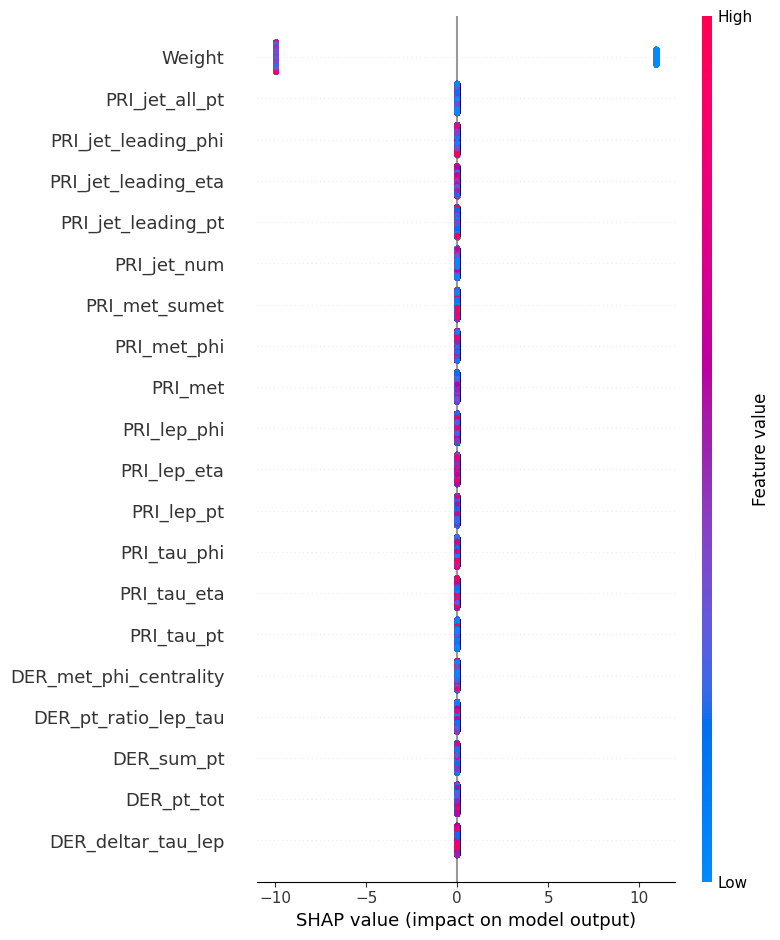

In [16]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)